In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA

from Dennis.larvee.larvee_utils import plot_larvee


# 0. Define functions

# 1. Load Data

In [169]:
# Load data: 
# data_use_name = "../larvee_datasets_irina/centered/video2_centered.npy"
# data_use_name = "../larvee_datasets_irina/centered/video3_centered.npy"
# data_use_name = "../larvee_datasets_irina/rotated/video2_rotated.npy"
data_use_name = "../larvee_datasets_irina/rotated/video3_rotated.npy"

data_use = np.load(data_use_name)
print(f"{data_use.shape=}")

data_use.shape=(2999, 22, 2)


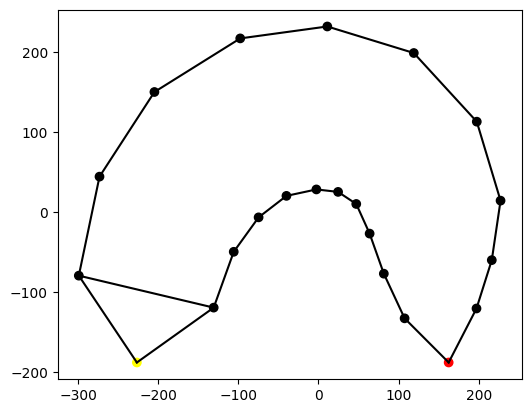

In [170]:
# plot one frame: 
frame = 100

plot_larvee.plot_single_frame_data(data_use[frame, :, :])

### 2.2: PCA analysis

In [171]:
# Do PCA: 

new_shape = (data_use.shape[0], data_use.shape[1] * data_use.shape[2])
data_for_pca = data_use.reshape(new_shape)
print(f"{data_for_pca.shape=}")
pca = PCA()

pca.fit(data_for_pca)

data_for_pca.shape=(2999, 44)


PCA()

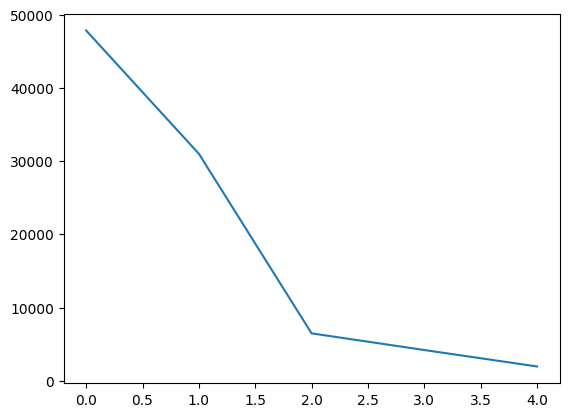

In [172]:
# Plot explained variance: 
evs = pca.explained_variance_
plt.plot(evs[:5])

In [173]:
# components: 
pcs = pca.components_  #n components x n_features
print(f"{pcs.shape=}")

pcs.shape=(44, 44)


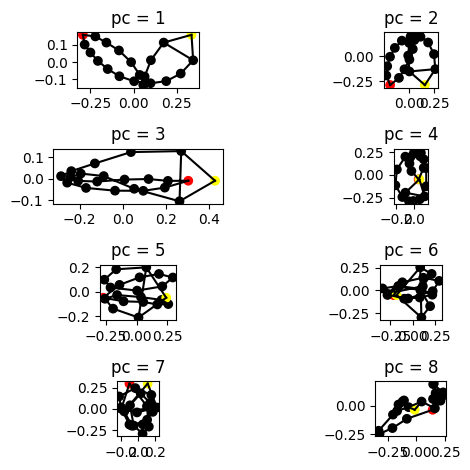

In [174]:
fig, axs = plt.subplots(4, 2)
axs = axs.flatten()
for i_ax, ax in enumerate(axs):
    pc = pcs[i_ax, :]
    pc_reshaped = pc.reshape((data_use.shape[1:]))
    plot_larvee.plot_single_frame_data(pc_reshaped, ax)
    ax.set_title(f"pc = {i_ax + 1}")
fig.tight_layout()

n_components =1
n_components =2
n_components =3
n_components =4
n_components =8
n_components =10
n_components =15
n_components =20


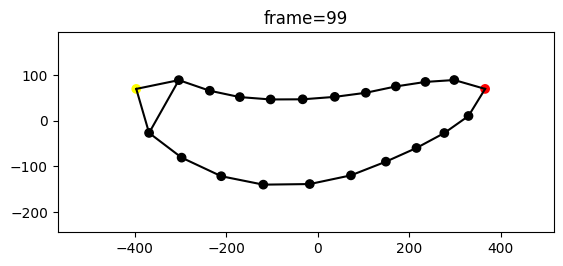

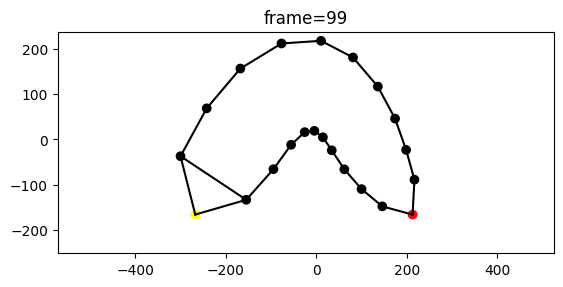

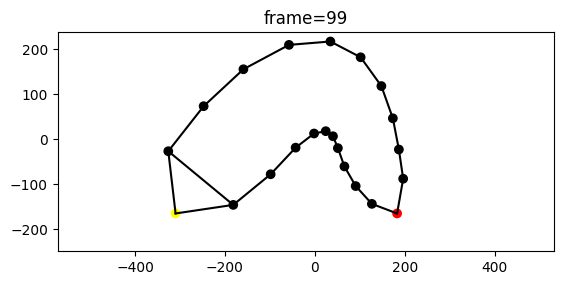

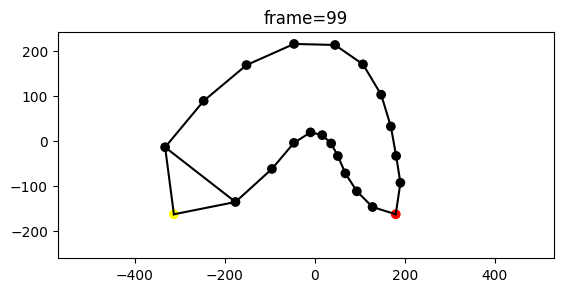

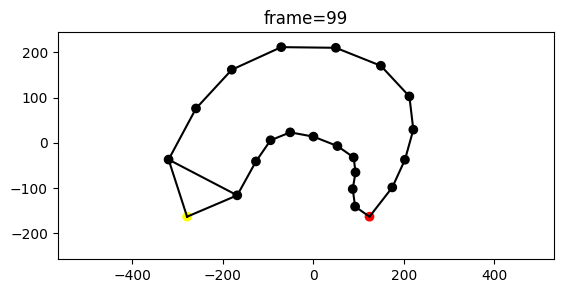

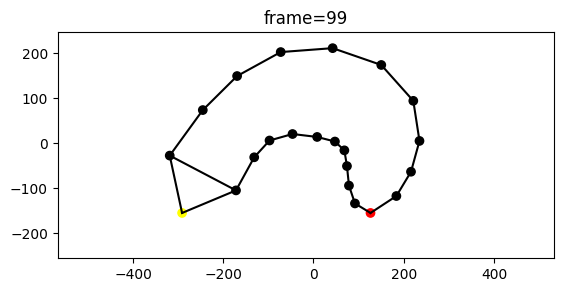

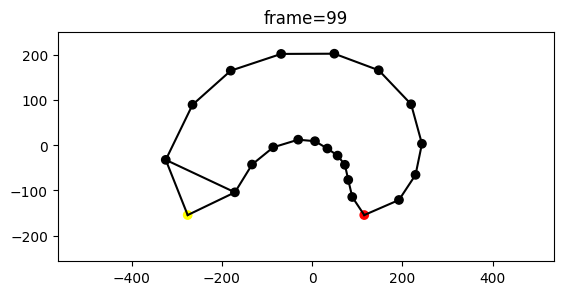

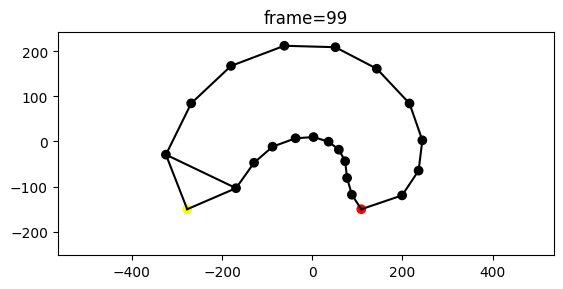

In [175]:
# reconstruction error:
nr_samples = data_use.shape[0]

for n_components in [1, 2, 3, 4, 8, 10, 15, 20]:
    print(f"{n_components =}")

    pca = PCA(n_components=n_components)
    data_recon = pca.inverse_transform(pca.fit_transform(data_use.reshape(nr_samples, 44))).reshape((nr_samples, 22, 2))

    plot_larvee.animate_and_save(data=data_recon,
                                 file_name=f"pc_reconstruction/pc_reconstruction_v3__n_{n_components}.gif")

# 3. Maximally predictive states

In [176]:
import deeptime as dtime

from utils_dennis.maximally_predictive_states import (time_delay_embedding,
                                                      cluster_data,
                                                      compare_time_series,
                                                      get_entropy
                                                      )

#### 3.1 Prepare data

- Take the centered data of shape (timesteps, 22, 2) and transform it to (timesteps, 44). 

In [177]:
print(f"{data_use.shape=}")
X = data_use.reshape((data_use.shape[0], 44))
print(f"{X.shape=}")

data_use.shape=(2999, 22, 2)
X.shape=(2999, 44)


#### 3.2 Timedelay-embedding + clustering

In [191]:
K = 21  # 3 is interesting
n_clusters = 300

delay = K - 1

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             # algorithm="minibatchkmeans"
                                             algorithm="kmeans"
                                             )
print(f"{labels.shape=}")
print(f"{centers.shape=}")

print(f"K = {K} = {K/5} seconds.")

# check if all centers have labels: 
print(f"{np.unique(labels).size=} (should be {n_clusters=})")

traj_matrix.shape=(2979, 924)
labels.shape=(2979,)
centers.shape=(300, 924)
K = 21 = 4.2 seconds.
np.unique(labels).size=300 (should be n_clusters=300)


traj_matrix_reconstructed.shape=(2979, 924)


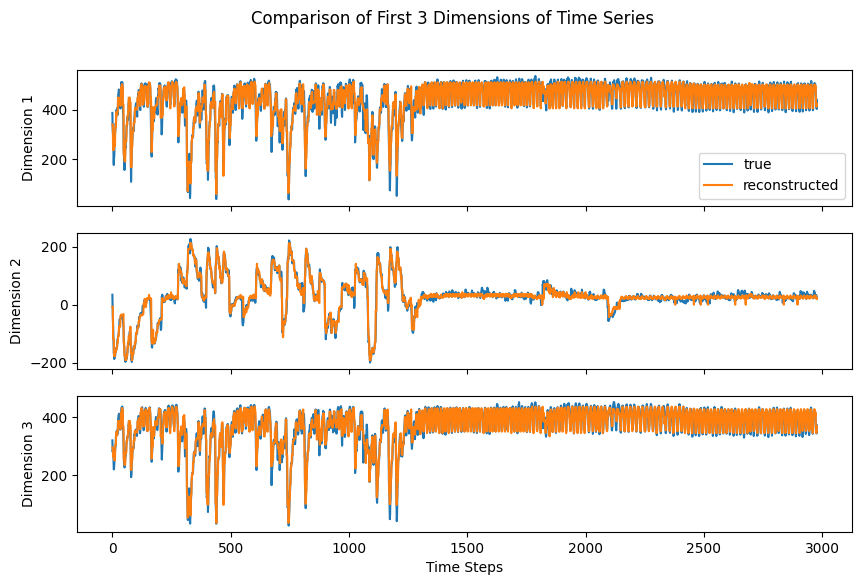

In [192]:
# reconstruct timeseries: 
traj_matrix_reconstructed = centers[labels, :]
print(f"{traj_matrix_reconstructed.shape=}")

# plot reconstruction: 
compare_time_series(traj_matrix[:, :], traj_matrix_reconstructed[:, :], k=3,
                    label1="true", label2="reconstructed")

#### 3.3 Create transition matrix with deeptime: 

connected_bool=False


Text(0, 0.5, 'states')

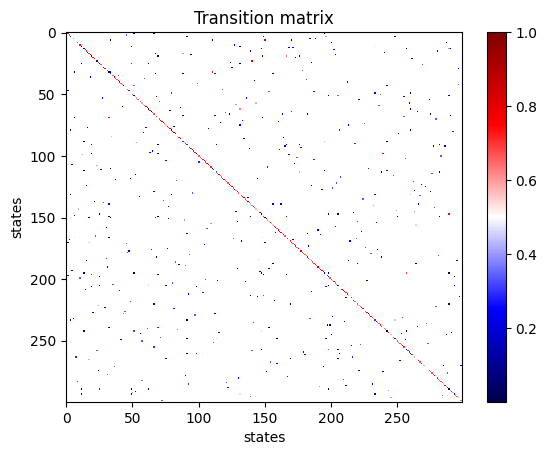

In [193]:
lag = 1

# count matrix: 
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=True)

# check if connected
connected_bool = dtime.markov.tools.analysis.is_connected(C, directed=True)
print(f"{connected_bool=}")

P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(P.toarray(), cmap=cmap, interpolation='nearest', aspect='auto', vmin=0.0001,
           vmax=1)
plt.colorbar()
plt.title("Transition matrix")
plt.xlabel("states")
plt.ylabel("states")

#### 3.4 Sample Markov model

In [194]:
msm = dtime.markov.msm.MarkovStateModel(P)

start_time = 400

start_state_real_space = traj_matrix[[start_time], :]
print(f"{start_state_real_space.shape=}")
start_state_discrete = kmeans_model.predict(start_state_real_space)
print(f"{start_state_discrete.shape=}")

n_steps = 1000
simulated_labels = msm.simulate(n_steps=n_steps, start=start_state_discrete, dt=1,
                                seed=1)
print(f"{simulated_labels.shape=}")

simulated_real_space = centers[simulated_labels]
print(f"{simulated_real_space.shape=}")

start_state_real_space.shape=(1, 924)
start_state_discrete.shape=(1,)
simulated_labels.shape=(1000,)
simulated_real_space.shape=(1000, 924)


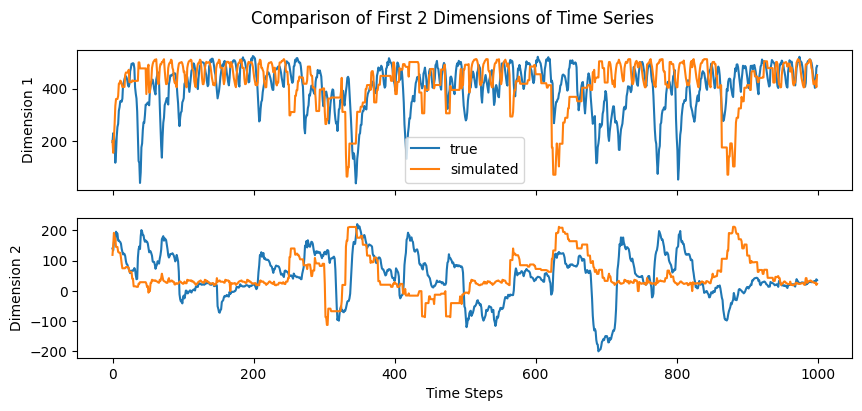

In [195]:
# plot reconstruction: 
time_window = 1000

compare_time_series(traj_matrix[start_time:start_time + time_window, :],
                    simulated_real_space[:time_window, :], k=2, label1="true",
                    label2="simulated")

In [196]:
reconstructed_larvee = simulated_real_space[:, :44].reshape((time_window, 22, 2))

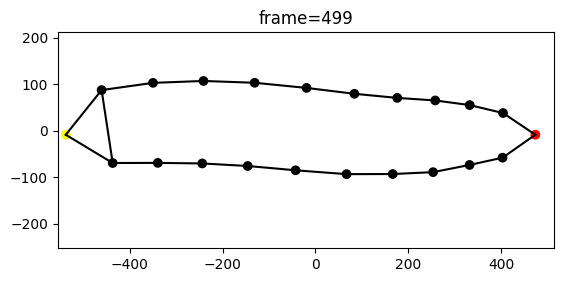

In [197]:
# Markov simulation: 

#calculate fps: 
fps = int(10 / lag)

plot_larvee.animate_and_save(data=reconstructed_larvee,
                             file_name=f"markov_larvee/markov_larvee_v3.gif",
                             num_frames=500, 
                             fps=fps)

#### 3.5 Define entropy function as a function of the transition matrix: 

In [185]:
# Calculate entropy of labels: 

get_entropy(transition_matrix=P)

0.8068424287022933

In [186]:
# Calculate entropy for various delays and number of clusters. 
lag_use = 1

# K_list = np.arange(1, 30, 2, dtype=int)
K_list = np.arange(1, 25, 4, dtype=int)
# n_clusters_list = np.array(np.logspace(2, 3, 4), dtype=int)
# n_clusters_list = np.array([100, 200, 500, 1000, 1500], dtype=int)
# n_clusters_list = np.array([100, 200, 500, 1000, 1500], dtype=int)
# n_clusters_list = np.arange(100, 1501, 25)
n_clusters_list = np.arange(100, 1001, 100)
entropy_data = np.zeros((len(K_list), len(n_clusters_list)))
for i_K, K in enumerate(K_list):
    delay = K - 1
    traj_matrix_use = time_delay_embedding(data=X, delay=delay)
    for i_n_clusters, n_clusters in enumerate(n_clusters_list):
        labels_use, _, _ = cluster_data(data=traj_matrix_use, 
                                        n_clusters=n_clusters,
                                        random_state=1, 
                                        # algorithm="minibatchkmeans", 
                                        algorithm="kmeans", 
                                        )
        C_use = dtime.markov.tools.estimation.count_matrix(labels_use,
                                                           lag=lag_use,
                                                           sliding=True)
        # C_use = dtime.markov.tools.estimation.largest_connected_submatrix(C_use, directed=True)
        print(f"{C_use.shape=}")
        connected_bool = dtime.markov.tools.analysis.is_connected(C_use, directed=True)
        print(f"{connected_bool=}")
        P_use = dtime.markov.tools.estimation.transition_matrix(C_use, reversible=False)
        entropy = get_entropy(P_use)
        entropy_data[i_K, i_n_clusters] = entropy
        print(f"Computed for {K} K and {n_clusters} clusters. entropy={entropy:.3f}")
        print(".....")

C_use.shape=(100, 100)
connected_bool=True
Computed for 1 K and 100 clusters. entropy=0.992
.....
C_use.shape=(200, 200)
connected_bool=True
Computed for 1 K and 200 clusters. entropy=1.102
.....
C_use.shape=(300, 300)
connected_bool=True
Computed for 1 K and 300 clusters. entropy=1.167
.....
C_use.shape=(400, 400)
connected_bool=False
Computed for 1 K and 400 clusters. entropy=1.155
.....
C_use.shape=(500, 500)
connected_bool=False
Computed for 1 K and 500 clusters. entropy=1.127
.....
C_use.shape=(600, 600)
connected_bool=True
Computed for 1 K and 600 clusters. entropy=1.097
.....
C_use.shape=(700, 700)
connected_bool=False
Computed for 1 K and 700 clusters. entropy=1.059
.....
C_use.shape=(800, 800)
connected_bool=False
Computed for 1 K and 800 clusters. entropy=1.045
.....
C_use.shape=(900, 900)
connected_bool=False
Computed for 1 K and 900 clusters. entropy=1.008
.....
C_use.shape=(1000, 1000)
connected_bool=False
Computed for 1 K and 1000 clusters. entropy=0.980
.....
C_use.shape

K_list=array([ 1,  5,  9, 13, 17, 21])
n_clusters_list=array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])
max_h_K=array([1.16747276, 0.9696423 , 0.94064423, 0.87530081, 0.826721  ,
       0.85348573])


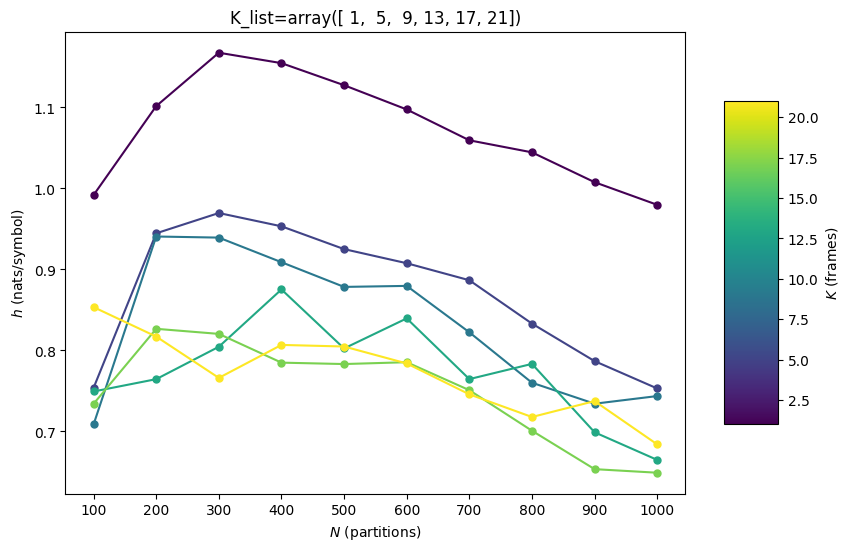

In [187]:
# lot entropy vs n_clusters and delays. 
colors_K = plt.cm.viridis(np.linspace(0, 1, len(K_list)))
max_h_K = np.zeros(len(K_list))
cil_h_K = np.zeros(len(K_list))
ciu_h_K = np.zeros(len(K_list))
max_idx_array = np.zeros(len(K_list), dtype=int)
plt.figure(figsize=(10, 6))

for k in range(len(K_list)):
    plt.errorbar(n_clusters_list, entropy_data[k], c=colors_K[int(k)], capsize=4,
                 marker='o', ms=5)
    max_idx = np.argmax(entropy_data[k])
    max_idx_array[k] = int(max_idx)
    max_h_K[k] = entropy_data[k][max_idx]

plt.scatter(n_clusters_list, entropy_data[k], c=entropy_data[k], vmin=min(K_list),
            vmax=max(K_list), s=0)
plt.colorbar(shrink=.7, aspect=6, label='$K$ (frames)')
plt.xlabel('$N$ (partitions)')
plt.ylabel('$h$ (nats/symbol)')
#plt.xscale('log')
plt.xticks(n_clusters_list)
plt.title(f"{K_list=}")

print(f"{K_list=}")
print(f"{n_clusters_list=}")
print(f"{max_h_K=}")

fn_cluster=300


Text(0.5, 1.0, 'n_cluster=300')

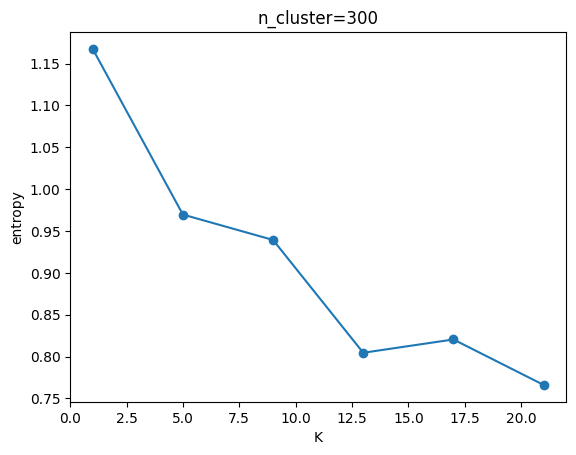

In [190]:
n_cluster_index = 2
n_cluster = n_clusters_list[n_cluster_index]
print(f"f{n_cluster=}")
plt.plot(K_list, entropy_data[:, n_cluster_index], marker='o')
plt.xlabel("K")
plt.ylabel("entropy")
plt.title(f"{n_cluster=}")


# More

[0 1 2 0 1 2]
connected_bool=True


Text(0.5, 1.0, 'stationary distribution')

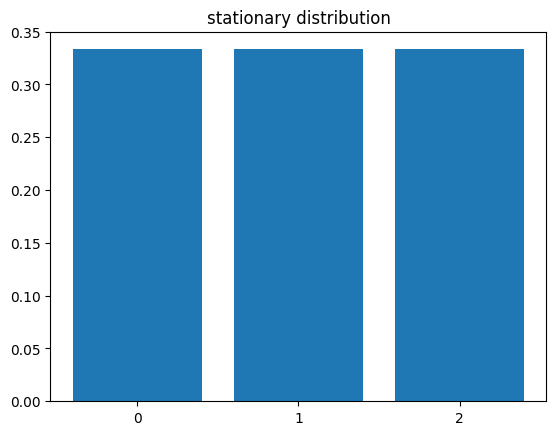

In [207]:
# testing some:
labels = np.array([0, 1, 2, 0, 1, 2])
print(labels)
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=1,
                                               sliding=True)
connected_bool = dtime.markov.tools.analysis.is_connected(C, directed=True)
print(f"{connected_bool=}")

P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

mu = dtime.markov.tools.analysis.stationary_distribution(P)

x = np.unique(labels)
plt.bar(x, mu)
plt.xticks(x)
plt.title("stationary distribution")

In [208]:
dtime.markov.tools.analysis.timescales(P)

ValueError: Number of time scales required for decomposition of sparse matrix

In [210]:
dtime.markov.tools.analysis.eigenvalues(P, k=2)

/home/dendun/PycharmProjects/maximally_predictive_states/venv/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


TypeError: Cannot use scipy.linalg.eig for sparse A with k >= N - 1. Use scipy.linalg.eig(A.toarray()) or reduce k.

In [214]:
import scipy
np.abs(scipy.linalg.eig(P.toarray())[0])

array([1., 1., 1.])